In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data_path
dir_data = './data/TW'
f_app_train = os.path.join(dir_data, '2020data_pchome1.CSV')
app_train = pd.read_csv(f_app_train)

In [2]:
app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,"$6,490",NaN
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,$599,NaN
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,$927,"$1,359"
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,$690,$990
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,"$1,055","$1,600"


In [3]:
# data processing

# 1. replace MSRP NaN value with price value
# 2. tranform type string to float for price and MSRP column
# 3. price and MSRP multiply prod_Q

import math

price_float = []
MSRP_float = []

for i in app_train.index:
    dollars = app_train['price'][i].replace("$","").replace(",","")
    price_float.append(float(dollars) * app_train['prod_Q'][i])
    if type(app_train['MSRP'][i]) == float:
        if math.isnan(app_train['MSRP'][i]):
            dollars = app_train['price'][i].replace("$","").replace(",","")
            MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
    else:
        dollars = app_train['MSRP'][i].replace("$","").replace(",","")
        MSRP_float.append(float(dollars) * app_train['prod_Q'][i])
        
app_train['price_float'] = price_float
app_train['MSRP_float'] = MSRP_float

app_train = app_train.drop(columns=['MSRP', 'price'])
app_train = app_train.rename(columns={"price_float": "price", "MSRP_float": "MSRP"})

app_train.head()

,member_id,postal_cd,date_cd,prod_id,goods,department,index,prod_Q,price,MSRP
0,15416142,831,day1,QAAD70-A9006TWM5-000,HP Officejet 7110 A3+ 網路高速印表機,3C,列 印,1,6490.0,6490.0
1,4663689,600,day1,QFAXAS-A900A38S1-001,HappyLife_桌上型微波爐架/烤箱置物架 (YV9799),生活,衛浴,1,599.0,599.0
2,8097088,815,day1,QFAAJY-A9009W99R-000,dayneeds_輕型 45x45x160cm 四層電鍍波浪收納鐵架,生活,傢俱,1,927.0,1359.0
3,15317712,708,day1,QAAS33-A900A7SR4-002,任天堂 Switch Joy-Con 四合一鋁合金 手把充電座(兩色可選),3C,電 玩,1,690.0,990.0
4,15438512,704,day1,CGAACT-A80423382-005,big5,運動戶外,汽百/記錄器,1,1055.0,1600.0


In [4]:
# calculate DFM data

# Discount = (1 - monetary_total)/MSRP_total
# Frequency = times of purchase
# Monetary = total of price

df = app_train.copy()

df1 = df.groupby('member_id').agg({'date_cd': np.size})
df2 = df.groupby('member_id')['price'].sum()
df3 = df.groupby('member_id')['MSRP'].sum()

df1['Monetary'] = df2
df1['MSRP_Total'] = df3
df3 = df1.rename(columns={'date_cd':'Frequency'})

discount = []
monetary =[]

for i in df3.index:
    discount.append((1 - round(df3['Monetary'][i]/df3['MSRP_Total'][i], 4)))
    monetary.append(format(int(df3['Monetary'][i]), ',d'))

df3['Discount'] = discount
# df3['Monetary'] = monetary
# df3['Monetary($)'] = monetary

df_DFM = pd.DataFrame()
df_DFM['Discount(%off)'] = df3['Discount']
df_DFM['Frequency'] = df3['Frequency']
# df_DFM['Monetary($)'] = df3['Monetary($)']
df_DFM['Monetary'] = df3['Monetary']
df_DFM.to_csv ('DFM.csv', index = False, header=True)
df_DFM.head()

,Discount(%off),Frequency,Monetary
member_id,,,
91,0.0000,2,2900.0
549,0.0913,1,2090.0
1655,0.1466,1,2799.0
2241,0.4196,2,1025.0
2988,0.5393,2,786.0


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\user\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


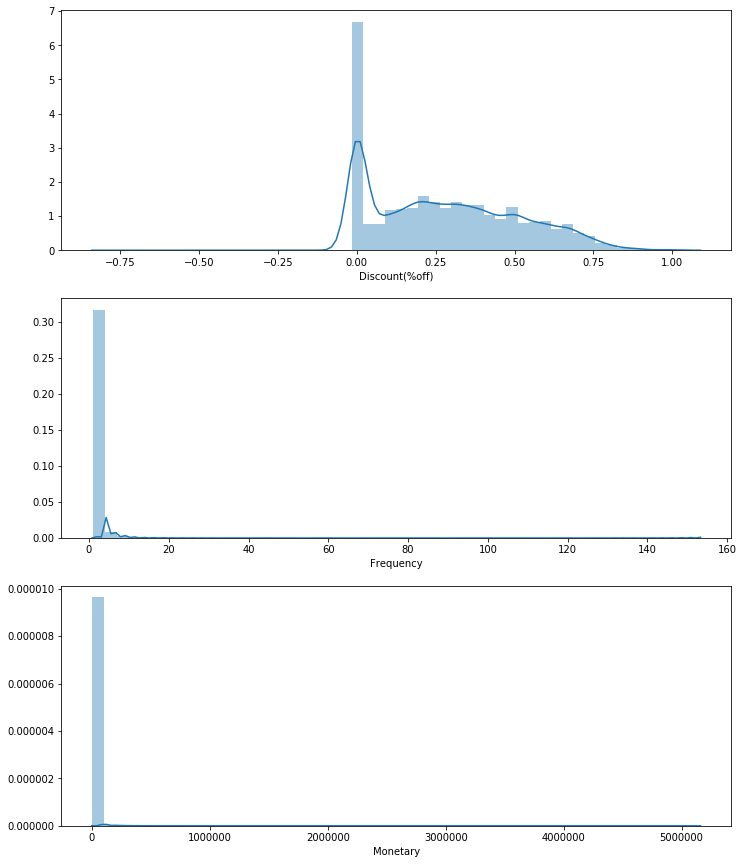

In [5]:
# Plot DFM distributions for probability density

# y-asix is probability density
# Cruve line is gaussian kernel density estimate

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); sns.distplot(df_DFM['Discount(%off)'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_DFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_DFM['Monetary'])
# Show the plot
plt.show()

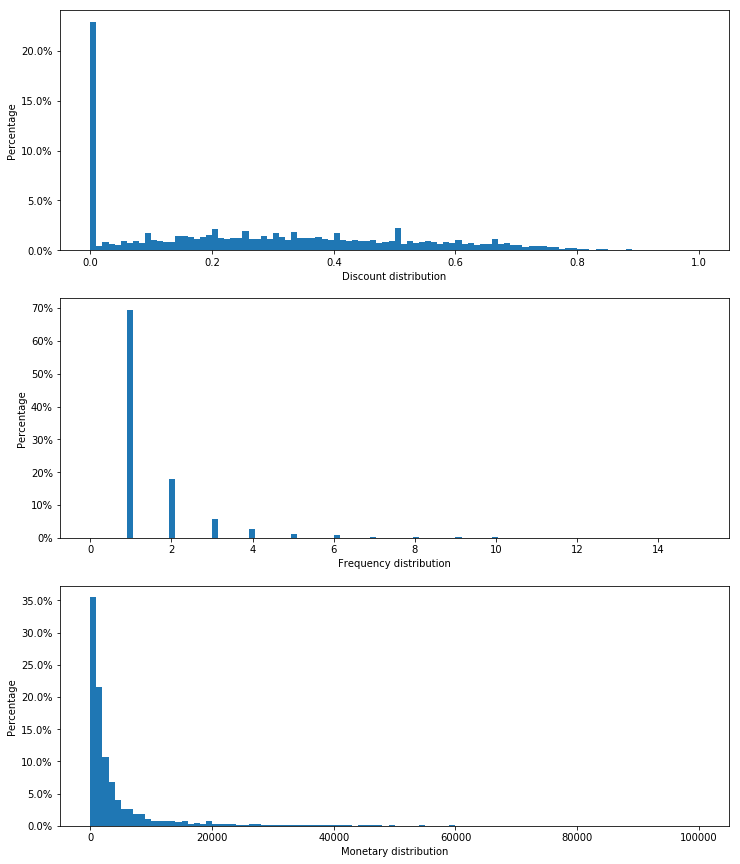

In [6]:
# Plot DFM distributions for probability

# y-asix is probability
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); 
weights = np.ones_like(np.array(df_DFM['Discount(%off)']))/float(len(np.array(df_DFM['Discount(%off)'])))
plt.xlabel('Discount distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Discount(%off)'], weights=weights, bins=100, range=(0,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Plot distribution of F
plt.subplot(3, 1, 2);
weights = np.ones_like(np.array(df_DFM['Frequency']))/float(len(np.array(df_DFM['Frequency'])))
plt.xlabel('Frequency distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Frequency'], weights=weights, bins=100, range=(0,15))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Plot distribution of M
plt.subplot(3, 1, 3);
weights = np.ones_like(np.array(df_DFM['Monetary']))/float(len(np.array(df_DFM['Monetary'])))
plt.xlabel('Monetary distribution')
plt.ylabel('Percentage')
plt.hist(df_DFM['Monetary'], weights=weights, bins=100, range=(0,100000))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig('DFM_Model.pdf')
# Show the plot
plt.show()


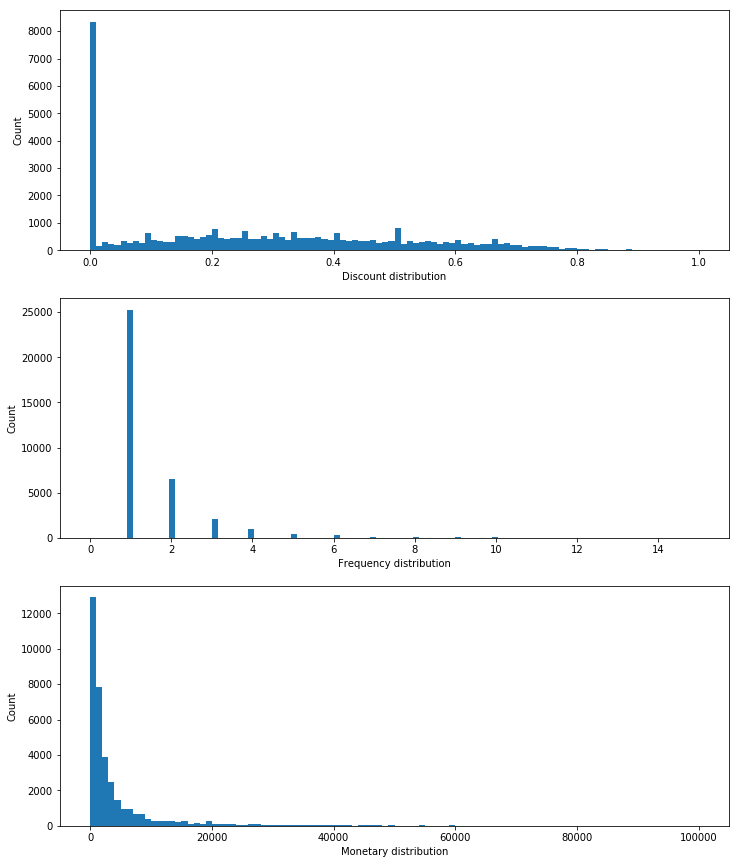

In [7]:
# Plot DFM distributions for count

# y-asix is count

plt.figure(figsize=(12,15))
# Plot distribution of D
plt.subplot(3, 1, 1); 
weights = np.ones_like(np.array(df_DFM['Discount(%off)']))
plt.xlabel('Discount distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Discount(%off)'], weights=weights, bins=100, range=(0,1))
# Plot distribution of F
plt.subplot(3, 1, 2);
weights = np.ones_like(np.array(df_DFM['Frequency']))
plt.xlabel('Frequency distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Frequency'], weights=weights, bins=100, range=(0,15))
# Plot distribution of M
plt.subplot(3, 1, 3);
weights = np.ones_like(np.array(df_DFM['Monetary']))
plt.xlabel('Monetary distribution')
plt.ylabel('Count')
plt.hist(df_DFM['Monetary'], weights=weights, bins=100, range=(0,100000))
# Show the plot
plt.show()

In [8]:
# Calculate z score

from scipy.stats import zscore

df = df_DFM.apply(zscore)

df_DFM['D_z-score'] = round(df['Discount(%off)'], 2)
df_DFM['F_z-score'] = round(df['Frequency'], 2)
df_DFM['M_z-score'] = round(df['Monetary'], 2)

discount = []
monetary =[]


for i in df_DFM.index:
    discount.append(format(df_DFM['Discount(%off)'][i], '.2%'))
    monetary.append(format(int(df_DFM['Monetary'][i]), ',d'))
    
df_DFM = df_DFM.rename(columns={'Monetary':'Monetary($)'})
df_DFM['Discount(%off)'] = discount
df_DFM['Monetary($)'] = monetary
df_DFM.head()

,Discount(%off),Frequency,Monetary($),D_z-score,F_z-score,M_z-score
member_id,,,,,,
91,0.00%,2,"2,900",-1.19,0.16,-0.09
549,9.13%,1,"2,090",-0.80,-0.30,-0.11
1655,14.66%,1,"2,799",-0.56,-0.30,-0.09
2241,41.96%,2,"1,025",0.62,0.16,-0.14
2988,53.93%,2,786,1.13,0.16,-0.14


In [9]:
# calculate VS(Value Score)＝ 1.25*ZD + 1* ZF + 1.5* ZM, Weight of DFM

vsScore = []

for i in df_DFM.index:
    vsScore.append(round(1.25 * df_DFM['D_z-score'][i] + 1 * df_DFM['F_z-score'][i] + 1.5 * df_DFM['M_z-score'][i], 2))

df_DFM['ValueScore'] = vsScore
df_DFM.head()

,Discount(%off),Frequency,Monetary($),D_z-score,F_z-score,M_z-score,ValueScore
member_id,,,,,,,
91,0.00%,2,"2,900",-1.19,0.16,-0.09,-1.46
549,9.13%,1,"2,090",-0.80,-0.30,-0.11,-1.46
1655,14.66%,1,"2,799",-0.56,-0.30,-0.09,-1.14
2241,41.96%,2,"1,025",0.62,0.16,-0.14,0.73
2988,53.93%,2,786,1.13,0.16,-0.14,1.36


In [10]:
# Rank by Value Score

df_DFM['Rank_ValueScore'] = df_DFM['ValueScore'].rank(method='min', ascending=False)
df_DFM_rank = df_DFM.sort_values(by='ValueScore', ascending=False)
result = df_DFM_rank.reset_index()
result.index += 1
result.head()

,member_id,Discount(%off),Frequency,Monetary($),D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore
1,2400440,0.00%,2,"5,160,000",-1.19,0.16,136.72,203.75,1.0
2,14255682,0.00%,132,"1,084,578",-1.19,59.89,28.61,101.32,2.0
3,17871662,1.56%,27,"2,245,276",-1.12,11.65,59.40,99.35,3.0
4,16574617,0.00%,153,"579,500",-1.19,69.53,15.21,90.86,4.0
5,14685763,1.11%,35,"1,868,927",-1.14,15.32,49.42,88.02,5.0


In [11]:
# Top 20 % valuable customer

valuable = []
for i in result.index:
    if i <= (len(result.index) * 0.2):
        valuable.append('Valuable Customer')
    else:
        valuable.append('Potential Customer')

result['VS_Level'] = valuable

result.to_csv ('DFM_Score.csv', index = False, header=True)

result

,member_id,Discount(%off),Frequency,Monetary($),D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore,VS_Level
1,2400440,0.00%,2,"5,160,000",-1.19,0.16,136.72,203.75,1.0,Valuable Customer
2,14255682,0.00%,132,"1,084,578",-1.19,59.89,28.61,101.32,2.0,Valuable Customer
3,17871662,1.56%,27,"2,245,276",-1.12,11.65,59.40,99.35,3.0,Valuable Customer
4,16574617,0.00%,153,"579,500",-1.19,69.53,15.21,90.86,4.0,Valuable Customer
5,14685763,1.11%,35,"1,868,927",-1.14,15.32,49.42,88.02,5.0,Valuable Customer
6,11521175,2.49%,95,"735,971",-1.08,42.89,19.36,70.58,6.0,Valuable Customer
7,15651146,0.00%,65,"519,752",-1.19,29.10,13.63,48.06,7.0,Valuable Customer
8,17719417,0.00%,2,"1,146,000",-1.19,0.16,30.24,44.03,8.0,Valuable Customer
9,14114293,28.72%,55,"470,590",0.05,24.51,12.32,43.05,9.0,Valuable Customer
10,14875891,14.09%,42,"475,780",-0.58,18.54,12.46,36.50,10.0,Valuable Customer


In [12]:
# Filter top 20% valuable customer

valuableCustomer = result[result.VS_Level != 'Potential Customer']

valuableCustomer

,member_id,Discount(%off),Frequency,Monetary($),D_z-score,F_z-score,M_z-score,ValueScore,Rank_ValueScore,VS_Level
1,2400440,0.00%,2,"5,160,000",-1.19,0.16,136.72,203.75,1.0,Valuable Customer
2,14255682,0.00%,132,"1,084,578",-1.19,59.89,28.61,101.32,2.0,Valuable Customer
3,17871662,1.56%,27,"2,245,276",-1.12,11.65,59.40,99.35,3.0,Valuable Customer
4,16574617,0.00%,153,"579,500",-1.19,69.53,15.21,90.86,4.0,Valuable Customer
5,14685763,1.11%,35,"1,868,927",-1.14,15.32,49.42,88.02,5.0,Valuable Customer
6,11521175,2.49%,95,"735,971",-1.08,42.89,19.36,70.58,6.0,Valuable Customer
7,15651146,0.00%,65,"519,752",-1.19,29.10,13.63,48.06,7.0,Valuable Customer
8,17719417,0.00%,2,"1,146,000",-1.19,0.16,30.24,44.03,8.0,Valuable Customer
9,14114293,28.72%,55,"470,590",0.05,24.51,12.32,43.05,9.0,Valuable Customer
10,14875891,14.09%,42,"475,780",-0.58,18.54,12.46,36.50,10.0,Valuable Customer


In [ ]:
# Find Top 20 % valuable customer data

valuableData = pd.DataFrame(data=None, columns=app_train.columns)
for i in valuableCustomer.index:
    df = app_train[app_train.member_id == valuableCustomer['member_id'][i]]
    valuableData = valuableData.append(df, ignore_index=True)
    
prod_Q = []
for i in valuableData.index:
    prod_Q.append(int(valuableData['prod_Q'][i]))

valuableData['prod_Quantity'] = prod_Q
valuableData = valuableData.drop(columns=['prod_Q'])
valuableData = valuableData.rename(columns={'prod_Quantity':'prod_Q'})

SetRank = []

for i in valuableData.index:
    SetRank.append(i + 1)
    
valuableData['Rank'] = SetRank

valuableData = valuableData.reset_index()
valuableData.index += 1
valuableData = valuableData.drop(columns=['level_0'])
valuableData

In [ ]:
# Sum price group by index 

index = valuableData.groupby(['index']).sum()
index = index.sort_values(by='price', ascending=False)
index = index.reset_index()

top20 = []
for i in index.index:
    if i <= (len(index.index) * 0.2):
        top20.append('Valuable index')
    else:
        top20.append('Potential index')

index['Sales_Rank'] = top20

SetRank = []
for i in index.index:
    SetRank.append(i + 1)
    
index['Rank'] = SetRank

index = index.reset_index()
index.index += 1
index = index.drop(columns=['level_0'])
index = index.rename(columns={"price": "Sum of sales"})
index = index.rename(columns={"MSRP": "Sum of MSRP"})
index = index[["Rank", "index", "Sum of sales", "Sum of MSRP", "prod_Q", "Sales_Rank"]]

index.to_csv ('IndexSalesRank.csv', index = False, header=True)
index

In [ ]:
# filter top 20 % sales index

valuableSalesIndex = index[index.Sales_Rank != 'Potential index']

SetRank = []

for i in range(1, 33):
    SetRank.append(i)

valuableSalesIndex['Rank'] = SetRank

valuableSalesIndex = valuableSalesIndex.reset_index()
valuableSalesIndex.index += 1
valuableSalesIndex = valuableSalesIndex.drop(columns=['level_0'])

valuableSalesIndex.to_csv ('valuableSalesRank.csv', index = False, header=True)
valuableSalesIndex

In [ ]:
# Filter top 20 % prod_Q group by index 
valuableQuantityIndex = valuableSalesIndex.sort_values(by='prod_Q', ascending=False)
valuableQuantityIndex = valuableQuantityIndex.reset_index()
valuableQuantityIndex.index += 1

top20 = []
for i in valuableQuantityIndex.index:
    if i <= (len(valuableQuantityIndex.index) * 0.2):
        top20.append('Valuable index')
    else:
        top20.append('Potential index')

valuableQuantityIndex['Quantity_Rank'] = top20

SetRank = []
for i in valuableQuantityIndex.index:
    SetRank.append(i)
valuableQuantityIndex['Rank'] = SetRank

valuableQuantityIndex = valuableQuantityIndex.drop(columns=['level_0'])
valuableQuantityIndex.to_csv ('IndexQuantityRank.csv', index = False, header=True)

valuableQuantityIndex

In [ ]:
# Top 20 % valuable index data

valuableIndex = valuableQuantityIndex[valuableQuantityIndex.Quantity_Rank != 'Potential index']

valuableIndex = valuableIndex.reset_index()
valuableIndex.index += 1
valuableIndex = valuableIndex.drop(columns=['level_0'])

SetRank = []
for i in valuableIndex.index:
    SetRank.append(i)
valuableIndex['Rank'] = SetRank

valuableIndex.to_csv ('Top20ValuableIndex.csv', index = False, header=True)

valuableIndex

In [ ]:
# Find Top 3 quantity of product each index

Top3Product_furniture = valuableData.loc[valuableData['index'] == '傢俱']
Top3Product_furniture = Top3Product_furniture.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_furniture = Top3Product_furniture.sort_values(by='prod_Q', ascending=False)
Top3Product_furniture = Top3Product_furniture.head(3)
print(Top3Product_furniture)

Top3Product_download = valuableData.loc[valuableData['index'] == '下載']
Top3Product_download = Top3Product_download.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_download = Top3Product_download.sort_values(by='prod_Q', ascending=False)
Top3Product_download = Top3Product_download.head(3)
print(Top3Product_download)

Top3Product_storage = valuableData.loc[valuableData['index'] == '收納']
Top3Product_storage = Top3Product_storage.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_storage = Top3Product_storage.sort_values(by='prod_Q', ascending=False)
Top3Product_storage = Top3Product_storage.head(3)
print(Top3Product_storage)

Top3Product_preorder = valuableData.loc[valuableData['index'] == '預購']
Top3Product_preorder = Top3Product_preorder.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_preorder = Top3Product_preorder.sort_values(by='prod_Q', ascending=False)
Top3Product_preorder = Top3Product_preorder.head(3)
print(Top3Product_preorder)

Top3Product_lighting = valuableData.loc[valuableData['index'] == '燈飾']
Top3Product_lighting = Top3Product_lighting.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_lighting = Top3Product_lighting.sort_values(by='prod_Q', ascending=False)
Top3Product_lighting = Top3Product_lighting.head(3)
print(Top3Product_lighting)

Top3Product_kitchen = valuableData.loc[valuableData['index'] == '餐廚']
Top3Product_kitchen = Top3Product_kitchen.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_kitchen = Top3Product_kitchen.sort_values(by='prod_Q', ascending=False)
Top3Product_kitchen = Top3Product_kitchen.head(3)
print(Top3Product_kitchen)

Top3Product_appliances = valuableData.loc[valuableData['index'] == ' 廚房家電']
Top3Product_appliances = Top3Product_appliances.groupby(['prod_id', 'goods', 'index']).sum()
Top3Product_appliances = Top3Product_appliances.sort_values(by='prod_Q', ascending=False)
Top3Product_appliances = Top3Product_appliances.head(3)
print(Top3Product_appliances)

In [ ]:
# Find Top 21 product
Top21Product = Top3Product_furniture.append(Top3Product_download)
Top21Product = Top21Product.append(Top3Product_storage)
Top21Product = Top21Product.append(Top3Product_preorder)
Top21Product = Top21Product.append(Top3Product_lighting)
Top21Product = Top21Product.append(Top3Product_kitchen)
Top21Product = Top21Product.append(Top3Product_appliances)


Top21Product = Top21Product.drop(columns=['Rank'])

Top21Product = Top21Product.reset_index()
Top21Product.index += 1

Top21Product = Top21Product.rename(columns={"price": "Sum of sales"})
Top21Product = Top21Product.rename(columns={"MSRP": "Sum of MSRP"})

Top21Product.to_csv ('Top20Product.csv', index = False, header=True)
Top21Product